<a href="https://colab.research.google.com/github/jainmridul82/Encoder-Decoder-Architecture/blob/main/_FFNetworksWithPyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Outline
1) Recap of data

2) FFN with Pytorch tensors and autograd

3) Using Pytorch's NN -> Functional, Linear, Sequential & Pytorch's Optim

4) Moving things to CUDA

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.colors as mc
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
from sklearn.metrics import mean_squared_error,log_loss,accuracy_score
import seaborn as sns
import time
from IPython.display import HTML
import warnings
warnings.filterwarnings("ignore")
import torch
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_blobs

In [ ]:
torch.manual_seed(0)

In [ ]:
my_cmap=mc.LinearSegmentedColormap.from_list("",["red","yellow","green"])

# Generating Dataset

In [ ]:
data,labels=make_blobs(n_samples=1000,centers=4,n_features=2,random_state=0)
print(data.shape,labels.shape)

(1000, 2) (1000,)


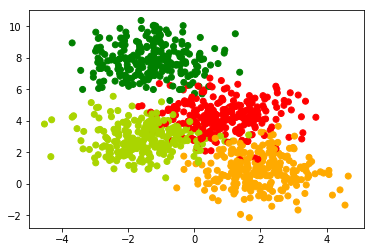

In [ ]:
plt.scatter(data[:,0],data[:,1],c=labels,cmap=my_cmap)
plt.show()

In [ ]:
X_train,X_val,Y_train,Y_val=train_test_split(data,labels,stratify=labels,random_state=0)
print(X_train.shape,X_val.shape,labels.shape)

(750, 2) (250, 2) (1000,)


# Using torch tensors and autograd

In [ ]:
X_train,Y_train,X_val,Y_val=map(torch.tensor,(X_train,Y_train,X_val,Y_val))

In [ ]:
print(X_train.shape,Y_train.shape)

torch.Size([750, 2]) torch.Size([750])


In [ ]:
def model(x):
  a1=torch.matmul(x,weights1)+bias1 # (N,2)*(2,2)->(N,2)
  h1=a1.sigmoid() # (N,2)
  a2=torch.matmul(h1,weights2)+bias2 # (N,2)*(2,4)+(1,4)->(N,4)
  h2=a2.exp()/a2.exp().sum(-1).unsqueeze(-1) # ->(N,4) or .sum(-1,keepdim=True)
  return h2

In [ ]:
def loss_fn(y_hat,y):
  return -(y_hat[range(y.shape[0]),y].log()).mean()

In [ ]:
def accuracy(y_hat,y):
  pred=torch.argmax(y_hat,dim=1)
  return (pred==y).float().mean()

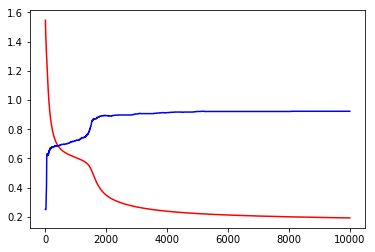

Loss before training:  1.5456441640853882
Loss after training:  0.19288592040538788


In [ ]:
torch.manual_seed(0)

weights1=torch.randn(2,2)/math.sqrt(2)
weights1.requires_grad_()
bias1=torch.zeros(2,requires_grad=True)

weights2=torch.randn(2,4)/math.sqrt(2)
weights2.requires_grad_()
bias2=torch.zeros(4,requires_grad=True)

lr=0.2
epochs=10000

X_train=X_train.float()
Y_train=Y_train.long()

loss_arr=[]
acc_arr=[]

for epoch in range(epochs):
  y_hat=model(X_train)
  loss=loss_fn(y_hat,Y_train)
  loss.backward()
  loss_arr.append(loss.item())
  acc_arr.append(accuracy(y_hat,Y_train))
  with torch.no_grad():
    weights1-=weights1.grad*lr
    bias1-=bias1.grad*lr
    weights2-=weights2.grad*lr
    bias2-=bias2.grad*lr
    weights1.grad.zero_()
    bias1.grad.zero_()
    weights2.grad.zero_()
    bias2.grad.zero_()

plt.plot(loss_arr,"r-")
plt.plot(acc_arr,"b-")
plt.show()
print("Loss before training: ",loss_arr[0])
print("Loss after training: ",loss_arr[-1])

# Using NN Functional

In [ ]:
import torch.nn.functional as F

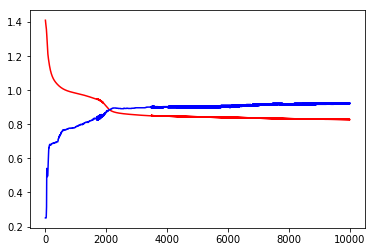

Loss before training:  1.4111980199813843
Loss after training:  0.8281410932540894


In [ ]:
torch.manual_seed(0)
weights1=torch.randn(2,2)/math.sqrt(2)
weights1.requires_grad_()
bias1=torch.zeros(2,requires_grad=True)
weights2=torch.randn(2,4)/math.sqrt(2)
weights2.requires_grad_()
bias2=torch.zeros(4,requires_grad=True)
lr=1.3
epochs=10000
loss_arr=[]
acc_arr=[]
for epoch in range(epochs):
  y_hat=model(X_train)
  loss=F.cross_entropy(y_hat,Y_train)
  loss.backward()
  loss_arr.append(loss.item())
  acc_arr.append(accuracy(y_hat,Y_train))
  with torch.no_grad():
    weights1-=weights1.grad*lr
    bias1-=bias1.grad*lr
    weights2-=weights2.grad*lr
    bias2-=bias2.grad*lr
    weights1.grad.zero_()
    bias1.grad.zero_()
    weights2.grad.zero_()
    bias2.grad.zero_()
plt.plot(loss_arr,"r-")
plt.plot(acc_arr,"b-")
plt.show()
print("Loss before training: ",loss_arr[0])
print("Loss after training: ",loss_arr[-1])

# Using NN parameter

In [ ]:
import torch.nn as nn

In [ ]:
class FirstNetwork(nn.Module):

  def __init__(self):
    super().__init__()
    torch.manual_seed(0)
    self.weights1=nn.Parameter(torch.randn(2,2)/math.sqrt(2))
    self.bias1=nn.Parameter(torch.zeros(2))
    self.weights2=nn.Parameter(torch.randn(2,4)/math.sqrt(2))
    self.bias2=nn.Parameter(torch.zeros(4))

  def forward(self,X):
    a1=torch.matmul(X,self.weights1)+self.bias1
    h1=a1.sigmoid()
    a2=torch.matmul(h1,self.weights2)+self.bias2
    h2=a2.exp()/a2.exp().sum(-1).unsqueeze(-1)
    return h2

In [ ]:
def fit(epochs=1000,lr=1):
  loss_arr=[]
  acc_arr=[]
  for epoch in range(epochs):
    y_hat=fn.forward(X_train)
    loss=F.cross_entropy(y_hat,Y_train)
    loss_arr.append(loss.item())
    acc_arr.append(accuracy(y_hat,Y_train))
    loss.backward()
    with torch.no_grad():
      for param in fn.parameters():
        param-=lr*param.grad
      fn.zero_grad()
  plt.plot(loss_arr,"r-")
  plt.plot(acc_arr,"b-")
  plt.show()
  print("Loss before training: ",loss_arr[0])
  print("Loss after training: ",loss_arr[-1])

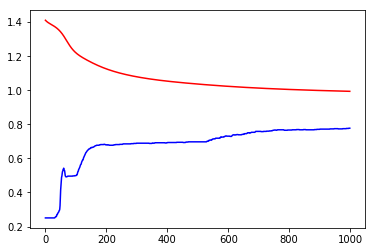

Loss before training:  1.4111980199813843
Loss after training:  0.9939236044883728


In [ ]:
fn=FirstNetwork()
fit()

# Using NN.Linear and Optim

In [ ]:
 class FirstNetwork_v1(nn.Module):

    def __init__(self):
      super().__init__()
      torch.manual_seed(0)
      self.lin1=nn.Linear(2,2)
      self.lin2=nn.Linear(2,4)

    def forward(self,X):
      a1=self.lin1(X)
      h1=a1.sigmoid()
      a2=self.lin2(h1)
      h2=a2.exp()/a2.exp().sum(-1).unsqueeze(-1)
      return h2

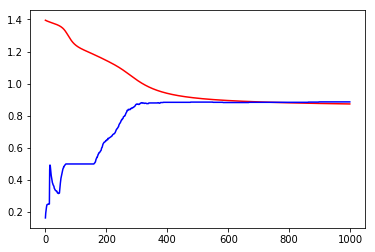

Loss before training:  1.395160436630249
Loss after training:  0.8738411664962769


In [ ]:
fn=FirstNetwork_v1()
fit()

In [ ]:
from torch import optim

In [ ]:
data,labels=make_blobs(n_samples=1000,n_features=2,centers=4,random_state=0)

X_train,X_test,Y_train,Y_test=train_test_split(data,labels,stratify=labels,random_state=0)
X_train,X_test,Y_train,Y_test=map(torch.tensor,(X_train,X_test,Y_train,Y_test))

X_train=X_train.float()
Y_train=Y_train.long()

In [ ]:
def accuracy(y_hat,y):
    y_pred=torch.argmax(y_hat,1)
    return (y_pred==y).float().mean()

In [ ]:
def fit_v1(epochs = 1000, learning_rate = 1):
  loss_arr = []
  acc_arr = []
  opt = optim.SGD(fn.parameters(), lr=learning_rate)

  for epoch in range(epochs):
    y_hat = fn(X_train)
    loss = F.cross_entropy(y_hat, Y_train)
    loss_arr.append(loss.item())
    acc_arr.append(accuracy(y_hat, Y_train))

    loss.backward()
    opt.step()
    opt.zero_grad()

  plt.plot(loss_arr, 'r-')
  plt.plot(acc_arr, 'b-')
  plt.show()
  print('Loss before training', loss_arr[0])
  print('Loss after training', loss_arr[-1])

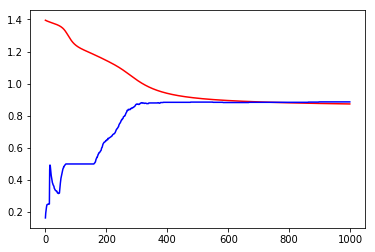

Loss before training 1.395160436630249
Loss after training 0.8738411664962769


In [ ]:
fn=FirstNetwork_v1()
fit_v1()

# Using NN.Sequential

In [ ]:
class FirstNetwork_v2(nn.Module):

  def __init__(self):
    super().__init__()
    torch.manual_seed(0)
    self.net = nn.Sequential(
        nn.Linear(2, 2),
        nn.Sigmoid(),
        nn.Linear(2, 4),
        nn.Softmax()
    )

  def forward(self, X):
    return self.net(X)

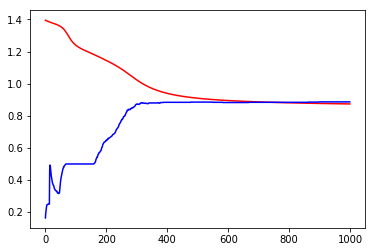

Loss before training 1.395160436630249
Loss after training 0.8738410472869873


In [ ]:
fn=FirstNetwork_v2()
fit_v1()

# Further Optimization

In [ ]:
class FirstNetwork_v2(torch.nn.Module):

  def __init__(self):
    super().__init__()
    torch.manual_seed(0)
    self.net=torch.nn.Sequential(
    torch.nn.Linear(2,2),
    torch.nn.Sigmoid(),
    torch.nn.Linear(2,4),
    torch.nn.Softmax())

  def forward(self,X):
    return self.net(X)

In [ ]:
def fit_v2(X,Y,model,opt,loss_fn,epochs=1):
  loss=loss_fn(model(X),Y)
  loss.backward()
